In [1]:
from torch.utils.data import Dataset
import torch
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
import torch
import random
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
from random import randint
from augment_functions import random_mask, resize_encoder, augment_sample, augment_sample_random_mask
from sklearn.metrics.pairwise import pairwise_distances

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
random.seed(42)
g = torch.Generator()
g.manual_seed(42)

In [3]:
def random_mask(sample, mask_prob=0.7):
    random_tensor = torch.rand(sample.shape, device=sample.device)
    mask = (random_tensor > mask_prob).float()
    masked_image = sample * mask
    return masked_image

class WeatherBenchDataset(Dataset):
    def __init__(self, data, mask_prob=0.7):
        self.data = data
        self.mask_prob = mask_prob
        
    def __len__(self):
        return (self.data.shape[0])

    def __getitem__(self, idx):
        x_orig = self.data[idx]
        x = resize_encoder(x_orig)
        masked_x = random_mask(x, mask_prob=self.mask_prob)
        masked_x_0_5 = random_mask(x, mask_prob=0.5)
        masked_x_0_3 = random_mask(x, mask_prob=0.3)
        y = idx
        return x_orig, x, masked_x, masked_x_0_3, masked_x_0_5, y

In [4]:
model = torch.load('simclr_decoder.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.model.encoder

BATCH_SIZE = 20
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.7)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.7)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)


In [5]:
def negative_cosine_sim_matrix(embeddings):
    z = F.normalize(embeddings, dim=1)
    sim_matrix = torch.matmul(z, z.T)
    N = sim_matrix.shape[0]
    mask = ~torch.eye(N, dtype=torch.bool, device=sim_matrix.device)
    negative_sims = sim_matrix[mask]
    return negative_sims


In [6]:
cos_sim_mean = []
rand_cos_sim_mean = []
mean_var = []
with torch.no_grad():
    for batch in testloader:
        X = batch[1].to(DEVICE)
        X_prime = batch[2].to(DEVICE)
        embeddings_x, _ = model(X)
        embeddings_x_prime, _ = model(X_prime)

        embeddings_x = embeddings_x.cpu()
        embeddings_x_prime = embeddings_x_prime.cpu()

        cos_sim = F.cosine_similarity(embeddings_x, embeddings_x_prime, dim=1)
        cos_sim_mean.append(cos_sim.mean().item())


        neg_cosine = negative_cosine_sim_matrix(embeddings_x)
        rand_cos_sim_mean.append(neg_cosine.mean().item())

        variance = embeddings_x.var(dim=0)
        mean_var.append(variance.mean().item())

cos_sim, rand_cos_sim, mean_var = np.mean(cos_sim_mean), np.mean(rand_cos_sim_mean), np.mean(mean_var)

print("Mean Cosine similarity:", cos_sim)
print("Negative Mean Cosine similarity:", rand_cos_sim)
print("Mean Variance of Embeddings", mean_var)


Mean Cosine similarity: 0.8986320085505135
Negative Mean Cosine similarity: 0.8516426491431701
Mean Variance of Embeddings 0.009656010935894953


In [7]:
# Grab a random batch
batch = list(testloader)[0]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([20, 5, 144, 72])


In [8]:
with torch.no_grad():
    embeddings_x, _ = model(x)
    embeddings_masked_x, _ = model(masked_x)
    embeddings_masked_x_0_3, _ = model(masked_x_0_3)
    embeddings_masked_x_0_5, _ = model(masked_x_0_5)

[3.4812822 3.3922176 3.626668  3.6661263 3.743623  3.082476  3.6569586
 3.7232585 3.8518612 3.4847288 3.4285703 3.4865553 3.1418736 3.7208016
 3.5511973 3.6247702 3.5189595 3.556319  3.594837  3.8828785]


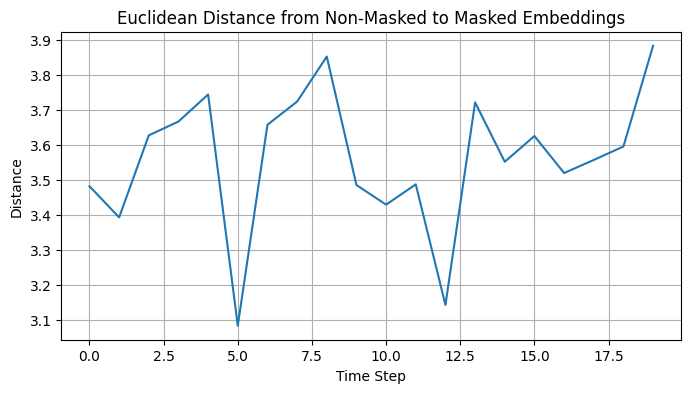

In [9]:
embeddings_x = embeddings_x.cpu()
embeddings_masked_x = embeddings_masked_x.cpu()
dist = np.linalg.norm(embeddings_x - embeddings_masked_x, axis=1)
print(dist)
plt.figure(figsize=(8, 4))
plt.plot(dist)
plt.title(f'Euclidean Distance from Non-Masked to Masked Embeddings')
plt.xlabel('Time Step')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

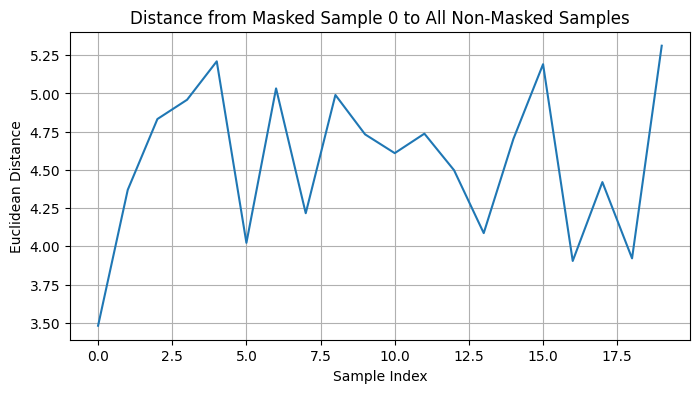

In [10]:
ref_embedding = embeddings_masked_x[0]  # shape: (embedding_dim,)
dist_to_all = np.linalg.norm(embeddings_x - ref_embedding, axis=1)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(dist_to_all)
plt.title('Distance from Masked Sample 0 to All Non-Masked Samples')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance')
plt.grid(True)
plt.show()

In [11]:
embeddings_x = embeddings_x.cpu().numpy()
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
embeddings_masked_x_0_3 = embeddings_masked_x_0_3.cpu().numpy()
embeddings_masked_x_0_5 = embeddings_masked_x_0_5.cpu().numpy()
y = y.cpu().numpy()

combined = np.vstack([embeddings_x, embeddings_masked_x, embeddings_masked_x_0_3, embeddings_masked_x_0_5])
pca = PCA(n_components = 2)
combined_proj = pca.fit_transform(combined)

x_proj = combined_proj[:len(embeddings_x)]
x_prime_proj = combined_proj[len(embeddings_x):len(embeddings_x)*2]
x_prime_proj_0_3 = combined_proj[len(embeddings_x)*2:len(embeddings_x)*3]
x_prime_proj_0_5 = combined_proj[len(embeddings_x)*3:len(embeddings_x)*4]


In [12]:
df = pd.DataFrame({
    'x': np.concatenate([x_proj[:, 0], x_prime_proj_0_3[:, 0], x_prime_proj_0_5[:, 0], x_prime_proj[:, 0]]),
    'y': np.concatenate([x_proj[:, 1], x_prime_proj_0_3[:, 1], x_prime_proj_0_5[:, 1], x_prime_proj[:, 1]]),
    'group': ['No Mask'] * BATCH_SIZE + ['30% Mask'] * BATCH_SIZE + ['50% Mask'] * BATCH_SIZE + ['70% Mask'] * BATCH_SIZE,
    'point_id': list(range(BATCH_SIZE)) * 4,
    'labels': list(y) *4
})

/tmp/ipykernel_4139330/4244481902.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_labels))


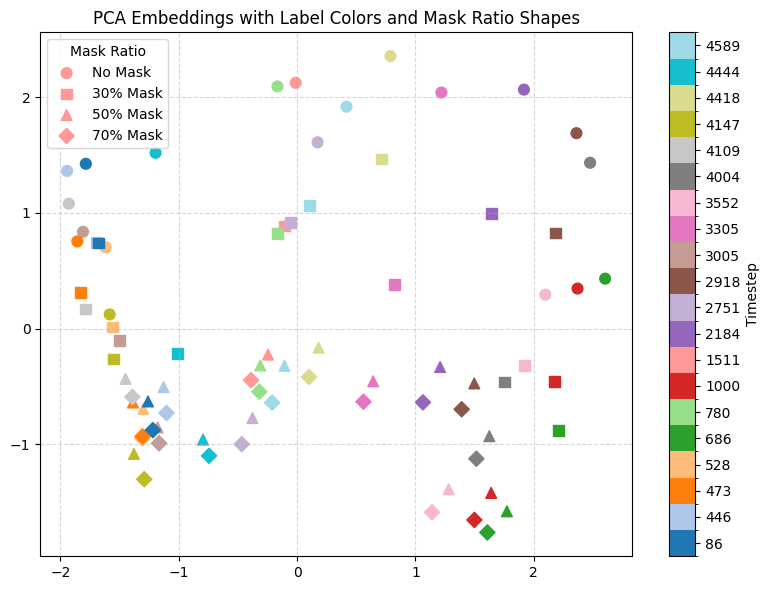

In [13]:
unique_labels = sorted(df['labels'].unique())
label_to_int = {label: i for i, label in enumerate(unique_labels)}
df['label_int'] = df['labels'].map(label_to_int)

cmap = plt.cm.get_cmap('tab20', len(unique_labels))
norm = mcolors.BoundaryNorm(np.arange(-0.5, len(unique_labels)+0.5), len(unique_labels))


markers = {'No Mask': 'o', '30% Mask': 's', '50% Mask': '^', '70% Mask': 'D'}

plt.figure(figsize=(8, 6))

for group, marker in markers.items():
    group_data = df[df['group'] == group]
    plt.scatter(
        group_data['x'],
        group_data['y'],
        c=group_data['label_int'],
        cmap=cmap,
        norm=norm,
        marker=marker,
        s=60,
        label=f'{group}'
    )

cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.set_label("Timestep")
cbar.ax.set_yticklabels(unique_labels)

plt.title("PCA Embeddings with Label Colors and Mask Ratio Shapes")
plt.legend(title='Mask Ratio')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [14]:
model = torch.load('simclr_decoder.pth', weights_only=False, map_location=DEVICE)
model.eval()

model = model.model.encoder

BATCH_SIZE = 256
data = torch.load('/vol/bitbucket/nb324/ERA5_64x32_daily_850.pt')
n_samples = data.shape[0]
n_train = int(n_samples * 0.6)
n_valid = int(n_samples * 0.2)
train_data = data[:n_train]
valid_data = data[n_train:n_train+n_valid]
test_data = data[n_train+n_valid:]

mean = train_data.mean(dim=(0, 2, 3), keepdim=True)
std = train_data.std(dim=(0, 2, 3), keepdim=True)

train_data = (train_data - mean) / std
test_dataset = WeatherBenchDataset(data=train_data, mask_prob=0.9)
trainloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_data = (test_data - mean) / std
test_dataset = WeatherBenchDataset(data=test_data, mask_prob=0.9)
testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [15]:
# Grab a random batch
batch = list(testloader)[3]

batch = next(iter(testloader))

x = batch[1].to(DEVICE)
masked_x = batch[2].to(DEVICE)
masked_x_0_3 = batch[3].to(DEVICE)
masked_x_0_5 = batch[4].to(DEVICE)
y = batch[5].to(DEVICE)

print(x.shape)

torch.Size([256, 5, 144, 72])


In [16]:
with torch.no_grad():
    embeddings_masked_x, _ = model(masked_x)

In [17]:
embeddings_masked_x = embeddings_masked_x.cpu().numpy()
y = y.cpu().numpy()

pca = PCA(n_components = 2)
x_proj = pca.fit_transform(embeddings_masked_x)


In [18]:
df = pd.DataFrame({
    'x': x_proj[:, 0],
    'y': x_proj[:, 1],
    'labels': y
})

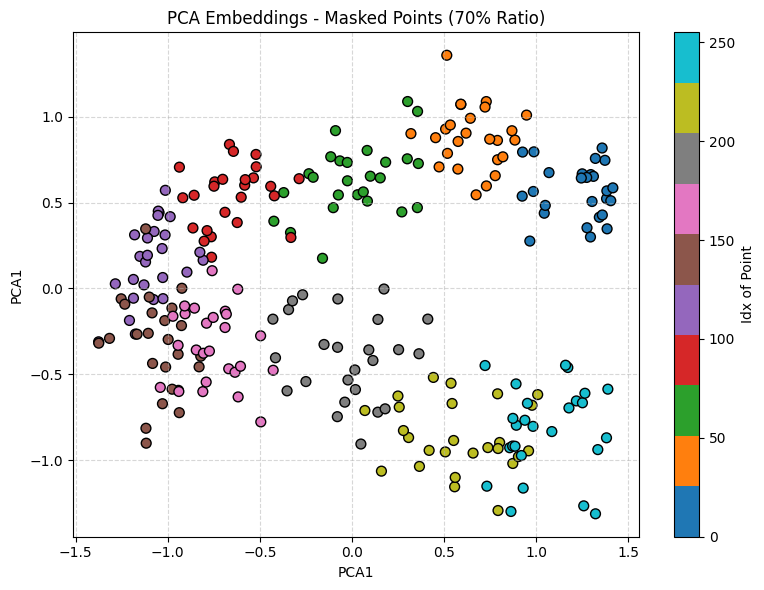

: 

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df['x'], df['y'], c=df['labels'], cmap='tab10', s=50, edgecolors='k')
plt.xlabel('PCA1')
plt.ylabel('PCA1')
plt.title('PCA Embeddings - Masked Points (70% Ratio)')
plt.colorbar(scatter, label='Idx of Point')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
